<a href="https://colab.research.google.com/github/flora0110/textsplit/blob/master/notebooks/HowTo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
!pip install word2vec

In [43]:
import os
from gensim.models import word2vec
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

## Download toy corpus for wordvector training and example text

In [44]:
corpus_path = './text8'  # be sure your corpus is cleaned from punctuation and lowercased
if not os.path.exists(corpus_path):
    !wget http://mattmahoney.net/dc/text8.zip
    !unzip {corpus_path}

links = {'tale2cities': 'https://www.gutenberg.org/files/98/98-0.txt',  # a tale of two cities
         'siddartha': 'http://www.gutenberg.org/cache/epub/2500/pg2500.txt'}  # siddartha

for link in links.values():
    text_path = os.path.basename(link)
    if not os.path.exists(text_path):
        !wget {link}

In [45]:
corpus_path
with open('./text8','r',encoding='utf-8') as file:
    for line in file.readlines():
        print(len(line))

100000000


## Train wordvectors

In [46]:
import logging
wrdvec_path = 'wrdvecs.bin'
if not os.path.exists(wrdvec_path):
  sentences = word2vec.Text8Corpus('./text8')
  model = word2vec.Word2Vec(sentences, cbow_mean=1, iter=5, hs=1, sample=0.00001, window=15, size=200)
  #word2vec.Word2Vec(corpus_path, wrdvec_path, cbow=1, iter_=5, hs=1, threads=8, sample='1e-5', window=15, size=200, binary=1)

2022-03-06 20:31:11,484 : INFO : collecting all words and their counts
2022-03-06 20:31:11,489 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-03-06 20:31:18,885 : INFO : collected 253854 word types from a corpus of 17005207 raw words and 1701 sentences
2022-03-06 20:31:18,887 : INFO : Loading a fresh vocabulary
2022-03-06 20:31:19,799 : INFO : effective_min_count=5 retains 71290 unique words (28% of original 253854, drops 182564)
2022-03-06 20:31:19,802 : INFO : effective_min_count=5 leaves 16718844 word corpus (98% of original 17005207, drops 286363)
2022-03-06 20:31:20,227 : INFO : deleting the raw counts dictionary of 253854 items
2022-03-06 20:31:20,245 : INFO : sample=1e-05 downsamples 3854 most-common words
2022-03-06 20:31:20,253 : INFO : downsampling leaves estimated 5567692 word corpus (33.3% of prior 16718844)
2022-03-06 20:31:20,429 : INFO : constructing a huffman tree from 71290 words
2022-03-06 20:31:24,483 : INFO : built huffman tree with 

In [47]:
model.save(wrdvec_path)

2022-03-06 20:34:29,037 : INFO : saving Word2Vec object under /text8.model, separately None
2022-03-06 20:34:29,038 : INFO : storing np array 'vectors' to /text8.model.wv.vectors.npy
2022-03-06 20:34:29,093 : INFO : not storing attribute vectors_norm
2022-03-06 20:34:29,094 : INFO : storing np array 'syn1' to /text8.model.trainables.syn1.npy
2022-03-06 20:34:29,142 : INFO : storing np array 'syn1neg' to /text8.model.trainables.syn1neg.npy
2022-03-06 20:34:29,206 : INFO : not storing attribute cum_table
2022-03-06 20:34:30,378 : INFO : saved /text8.model


In [48]:
model = word2vec.Word2Vec.load('/text8.model')
wrdvecs = pd.DataFrame(model.wv.vectors, index=model.wv.vocab)
# del model
print(wrdvecs.shape)

2022-03-06 20:34:30,392 : INFO : loading Word2Vec object from /text8.model
2022-03-06 20:34:30,876 : INFO : loading wv recursively from /text8.model.wv.* with mmap=None
2022-03-06 20:34:30,877 : INFO : loading vectors from /text8.model.wv.vectors.npy with mmap=None
2022-03-06 20:34:30,900 : INFO : setting ignored attribute vectors_norm to None
2022-03-06 20:34:30,901 : INFO : loading vocabulary recursively from /text8.model.vocabulary.* with mmap=None
2022-03-06 20:34:30,904 : INFO : loading trainables recursively from /text8.model.trainables.* with mmap=None
2022-03-06 20:34:30,907 : INFO : loading syn1 from /text8.model.trainables.syn1.npy with mmap=None
2022-03-06 20:34:30,937 : INFO : loading syn1neg from /text8.model.trainables.syn1neg.npy with mmap=None
2022-03-06 20:34:30,959 : INFO : setting ignored attribute cum_table to None
2022-03-06 20:34:30,963 : INFO : loaded /text8.model


(71290, 200)


## get sentence tokenizer

In [49]:
!pip install textsplit

In [50]:
from textsplit.tools import SimpleSentenceTokenizer
sentence_tokenizer = SimpleSentenceTokenizer()

## run get_penalty and split_optimal

In [51]:
%matplotlib inline
from textsplit.tools import get_penalty, get_segments
from textsplit.algorithm import split_optimal, split_greedy, get_total

penalty 43.04
8590 sentences, 366 segments, avg 23.47 sentences per segment
optimal score 266218.70, greedy score 265559.61
ratio of scores 1.0025


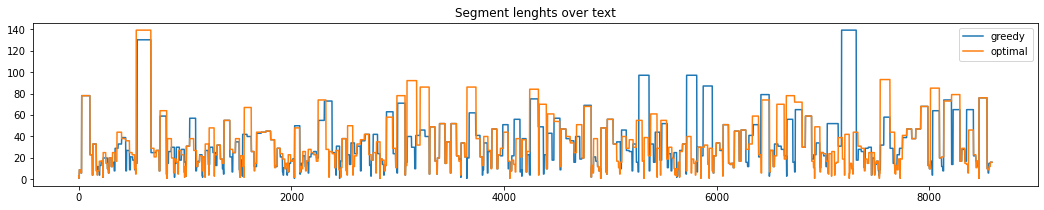

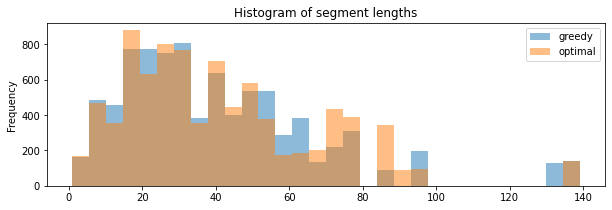

In [52]:
# link = links['siddartha']
link = links['tale2cities']
segment_len = 30  # segment target length in sentences
book_path = os.path.basename(link)

with open(book_path, 'rt') as f:
    text = f.read()  #.replace('\n', ' ')  # punkt tokenizer handles newlines not so nice

sentenced_text = sentence_tokenizer(text)
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(sentenced_text).dot(wrdvecs)

penalty = get_penalty([sentence_vectors], segment_len)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(sentenced_text, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(sentenced_text), len(segmented_text), len(sentenced_text) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(sentenced_text, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

## Evaluation

If you look into the written file `book_path`.seg, the snippet line is often at the boundary of a paragraph.  The word embeddings computed above are neither very good nor adapted to the text. Every unknown word has a zero vector. Choosing some more or less random vector for unknown words might improve the accuracy given those unknown terms appear repeatedly within a section.